# Stochastic Modelling of Pattern Formation

*citation:*
Twomey, Aidan. "On the stochastic modelling of reaction-diffusion processes." (2007).
https://core.ac.uk/download/pdf/1568321.pdf

$$
2U + V \xrightarrow{k1} 3U \quad\quad\text{(6.1)}\\
\emptyset \xrightarrow{k2} U \quad\quad\quad\quad\text{(6.2a)}\\
U \xrightarrow{k3} \emptyset \quad\quad\quad\quad\text{(6.2b)}\\
\emptyset \xrightarrow{k4} V \quad\quad\quad\quad\text{(6.3)}
$$

In [2]:
import os
import sys
from collections import OrderedDict
sys.path.append("../..")
import spatialpy
print(spatialpy.__file__)
import matplotlib.pyplot as plt
import numpy
%load_ext autoreload
%autoreload 2

/home/brian/Desktop/research/SpatialPy/examples/turing_pattern/../../spatialpy/__init__.py


In [3]:
class All(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return True

In [39]:
class turingPattern(spatialpy.Model):

    def __init__(self, model_name="turingPattern"):
        spatialpy.Model.__init__(self, model_name)

        U = spatialpy.Species(name="U", diffusion_constant=5e-4)
        V = spatialpy.Species(name="V", diffusion_constant=0.06)
        self.add_species([U,V])

        self.domain = spatialpy.Domain.create_2D_domain(nx=30, ny=30, xlim=[-1, 1], ylim=[-1, 1], fixed=True)

        self.set_type(All(), 1)

        k1 = spatialpy.Parameter("k1", expression=123.45)
        k2 = spatialpy.Parameter("k2", expression=0.09)
        k3 = spatialpy.Parameter("k3", expression=2.0)
        k4 = spatialpy.Parameter("k4", expression=1.5)
        self.add_parameter([k1, k2, k3, k4])

        Reaction1 = spatialpy.Reaction(reactants={U:2, V:1}, products={U:3}, 
                                       propensity_function="(U*(U-1)*V*k1)/vol")
        #Reaction1 = spatialpy.Reaction(reactants={U:2, V:1}, products={U:3}, rate="k1")
        Reaction2 = spatialpy.Reaction(reactants={}, products={U:1}, rate="k2")
        Reaction3 = spatialpy.Reaction(reactants={U:1}, products={}, rate="k3")
        Reaction4 = spatialpy.Reaction(reactants={}, products={V:1}, rate="k4")

        self.add_reaction([Reaction1, Reaction2, Reaction3, Reaction4])
        
        u_star = 0.18
        v_star = 0.065
        uv_scaling_factor = 1000

        self.add_initial_condition(spatialpy.ScatterInitialCondition(U, int(u_star*uv_scaling_factor), [1]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(V, int(v_star*uv_scaling_factor), [1]))

        self.staticDomain = True

        #self.timespan(range(0,50))
        self.timespan(numpy.linspace(0,1,11))

In [40]:
model = turingPattern()

In [57]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time sol.compile()
print(sol.build_dir)

CPU times: user 147 ms, sys: 6.14 ms, total: 154 ms
Wall time: 3.49 s
/tmp/spatialpy_build_qwxqtfcl


In [58]:
%time result = sol.run()

CPU times: user 2.93 ms, sys: 4.91 ms, total: 7.84 ms
Wall time: 1min 43s


In [59]:
speciesU = result.get_species("U")
speciesV = result.get_species("V")

In [60]:
speciesU.sum(axis=1)
speciesV.sum(axis=1)

array([65., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.])

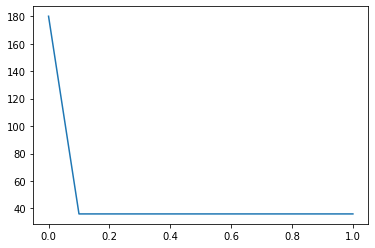

In [61]:
plt.plot(result.get_timespan(), speciesU.sum(axis=1))


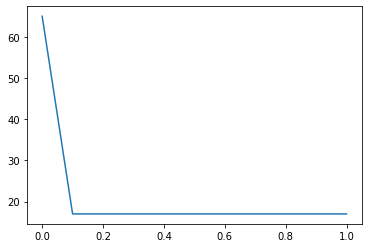

In [62]:
plt.plot(result.get_timespan(), speciesV.sum(axis=1))

In [63]:
#result.plot_species("U", animated=True)

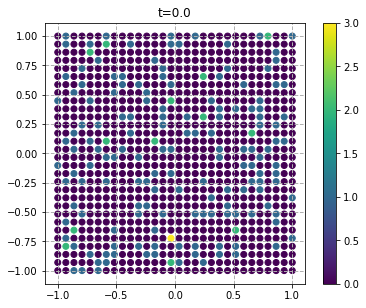

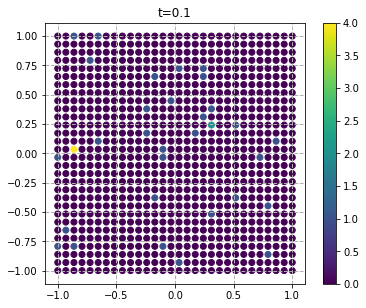

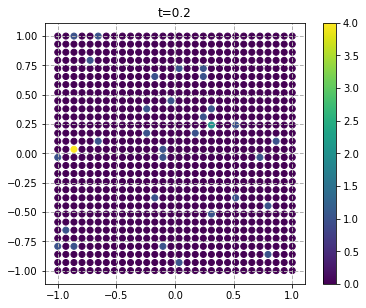

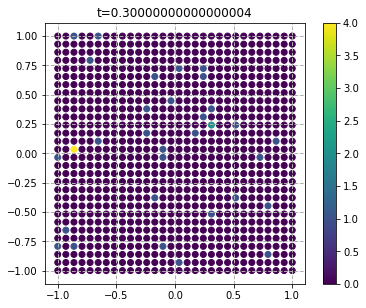

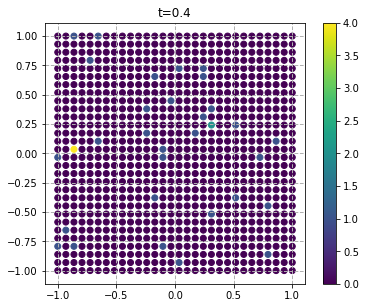

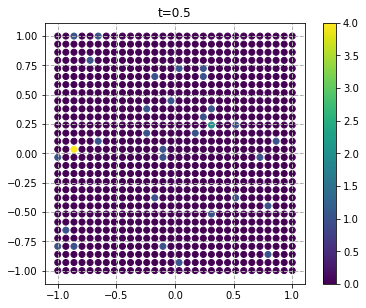

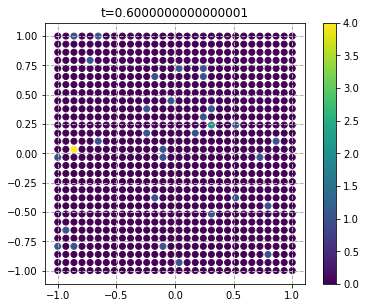

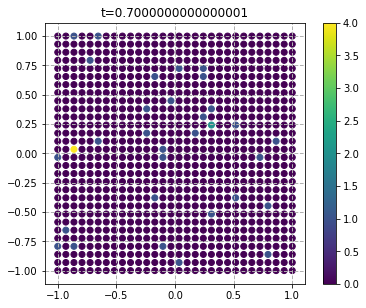

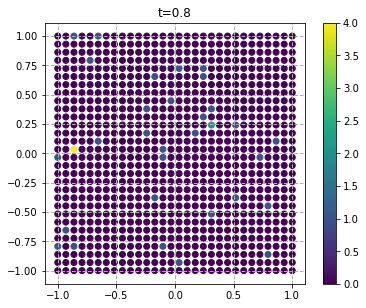

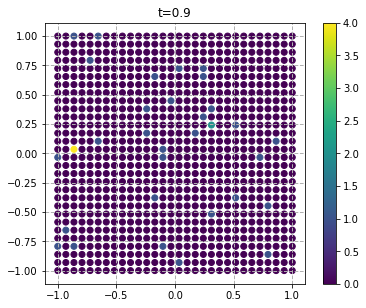

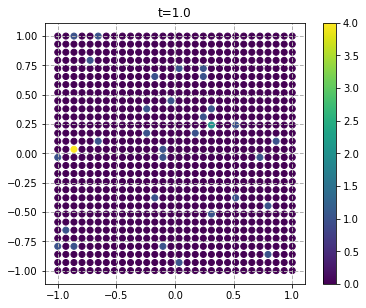

In [65]:
for i,t in enumerate(result.get_timespan()):
    #print(i,t)
    result.plot_species("U", i, use_matplotlib=True)
    plt.title(f"t={t}")